In [228]:
import numpy as np
from lattice import Lattice2D, BrickwallLatticeGeometry, RectangularLatticeGeometry, SimulationParameters, SimulationData, HexagonalLatticeGeometry, SquareLatticeGeometry, plot_site_grid
import matplotlib.pyplot as plt

params = SimulationParameters(-1, 1, np.array([0, -1]), 0.1, 10, 1, 1, 0.05)

# Finite Lattices in Tight Binding Model

## "Bloch" states

* Infinite lattice eigenstates are Bloch states, due to translation invariance. 
* Here, we simulate finite site amounts in nanoscale-systems with open boundaries (edge sites have finite hoppings only for neighbours inside lattice).
* According to (...), we expect linear combination of two bloch states with opposite wavevectors $\phi_{n\mathbf k} = \Phi_{n\mathbf k} + \Phi_{n\,-\mathbf k}$ as eigenstates.

### 1D
* Open boundary condition manifests in standing wave eigenfunction who would have zeros (nodes) at 0 and N+1 sites, see plot below.
* Hence, crystal length is N+1. We expect N standing wave eigenstates, k mode spacing $\frac{\pi}{N+1}$. Edge/surface states thus can't be modeled (we would expect 1 per band at FBZ end according to (...), but we don't model states there)

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.10.


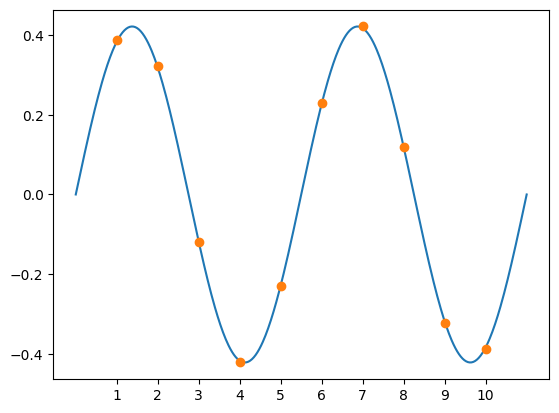

In [229]:
N = 10 # lattice/chain length
state_i = 3  # i^th eigenstate (i+1 antinodes)

l = Lattice2D(RectangularLatticeGeometry((N, 1)), params)
state = l.energy_states[:, state_i]

k = np.pi * (state_i + 1) / (N + 1)
A = max(np.abs(state)) * np.sign(state[int(np.pi / 2 / k)])

x_int, x_cont = np.arange(1, N + 1), np.linspace(0, N+1, 50*N)
plt.plot(x_cont, A * np.sin(k * x_cont))
plt.plot(x_int, state, "o")
plt.xticks(x_int)
plt.show()

### 1D with boundary sites
Adding two sites on the left and right of a 1D tight binding chain with N+2 sites, but without hopping connection, gives N standing wave eigenstates as above and two edge states where particles are fully localized on left or right edge sites. Respective eigenenergies are degenerate but not on band end as predicted in (...) - this might be due to the tight binding approximations.

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.08.


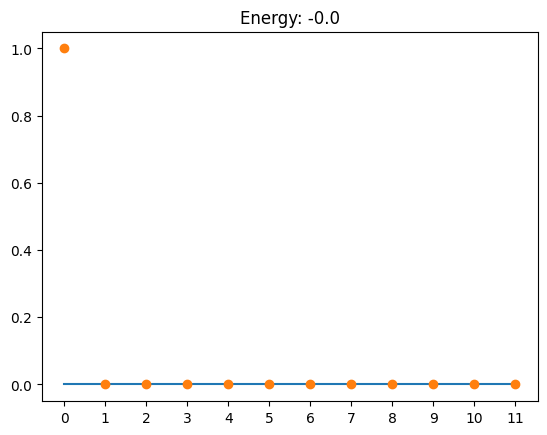

In [230]:
N = 10 # lattice/chain length
state_i = 5  # i^th eigenstate (i+1 antinodes)

l = Lattice2D(RectangularLatticeGeometry((N+2, 1)), params)

# set hopping tp edge sites to zero

H = l.H_hop
for hopping in [(0, 1), (1, 0), (N, N+1), (N+1, N)]:
    H[*hopping] = 0

evals, estates = np.linalg.eigh(H)
E, state = evals[state_i], estates[:, state_i]

if state_i > N/2: 
    state_i -=2 # skip edge states

k = np.pi * (state_i + 1) / (N + 1)
A = max(np.abs(state)) * np.sign(state[int(np.pi / 2 / k)+1])

x_int, x_cont = np.arange(0, N + 2), np.linspace(0, N+1, 50*N)
plt.plot(x_cont, A * np.sin(k * x_cont))
plt.plot(x_int, state, "o")
plt.title(f"Energy: {E}")
plt.xticks(x_int)
plt.show()

### 2D Eigenstates
2D Eigenstates are standing waves in x and y direction, formed by superposition of two bloch states as in 1D. Example plotted below.

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.05.


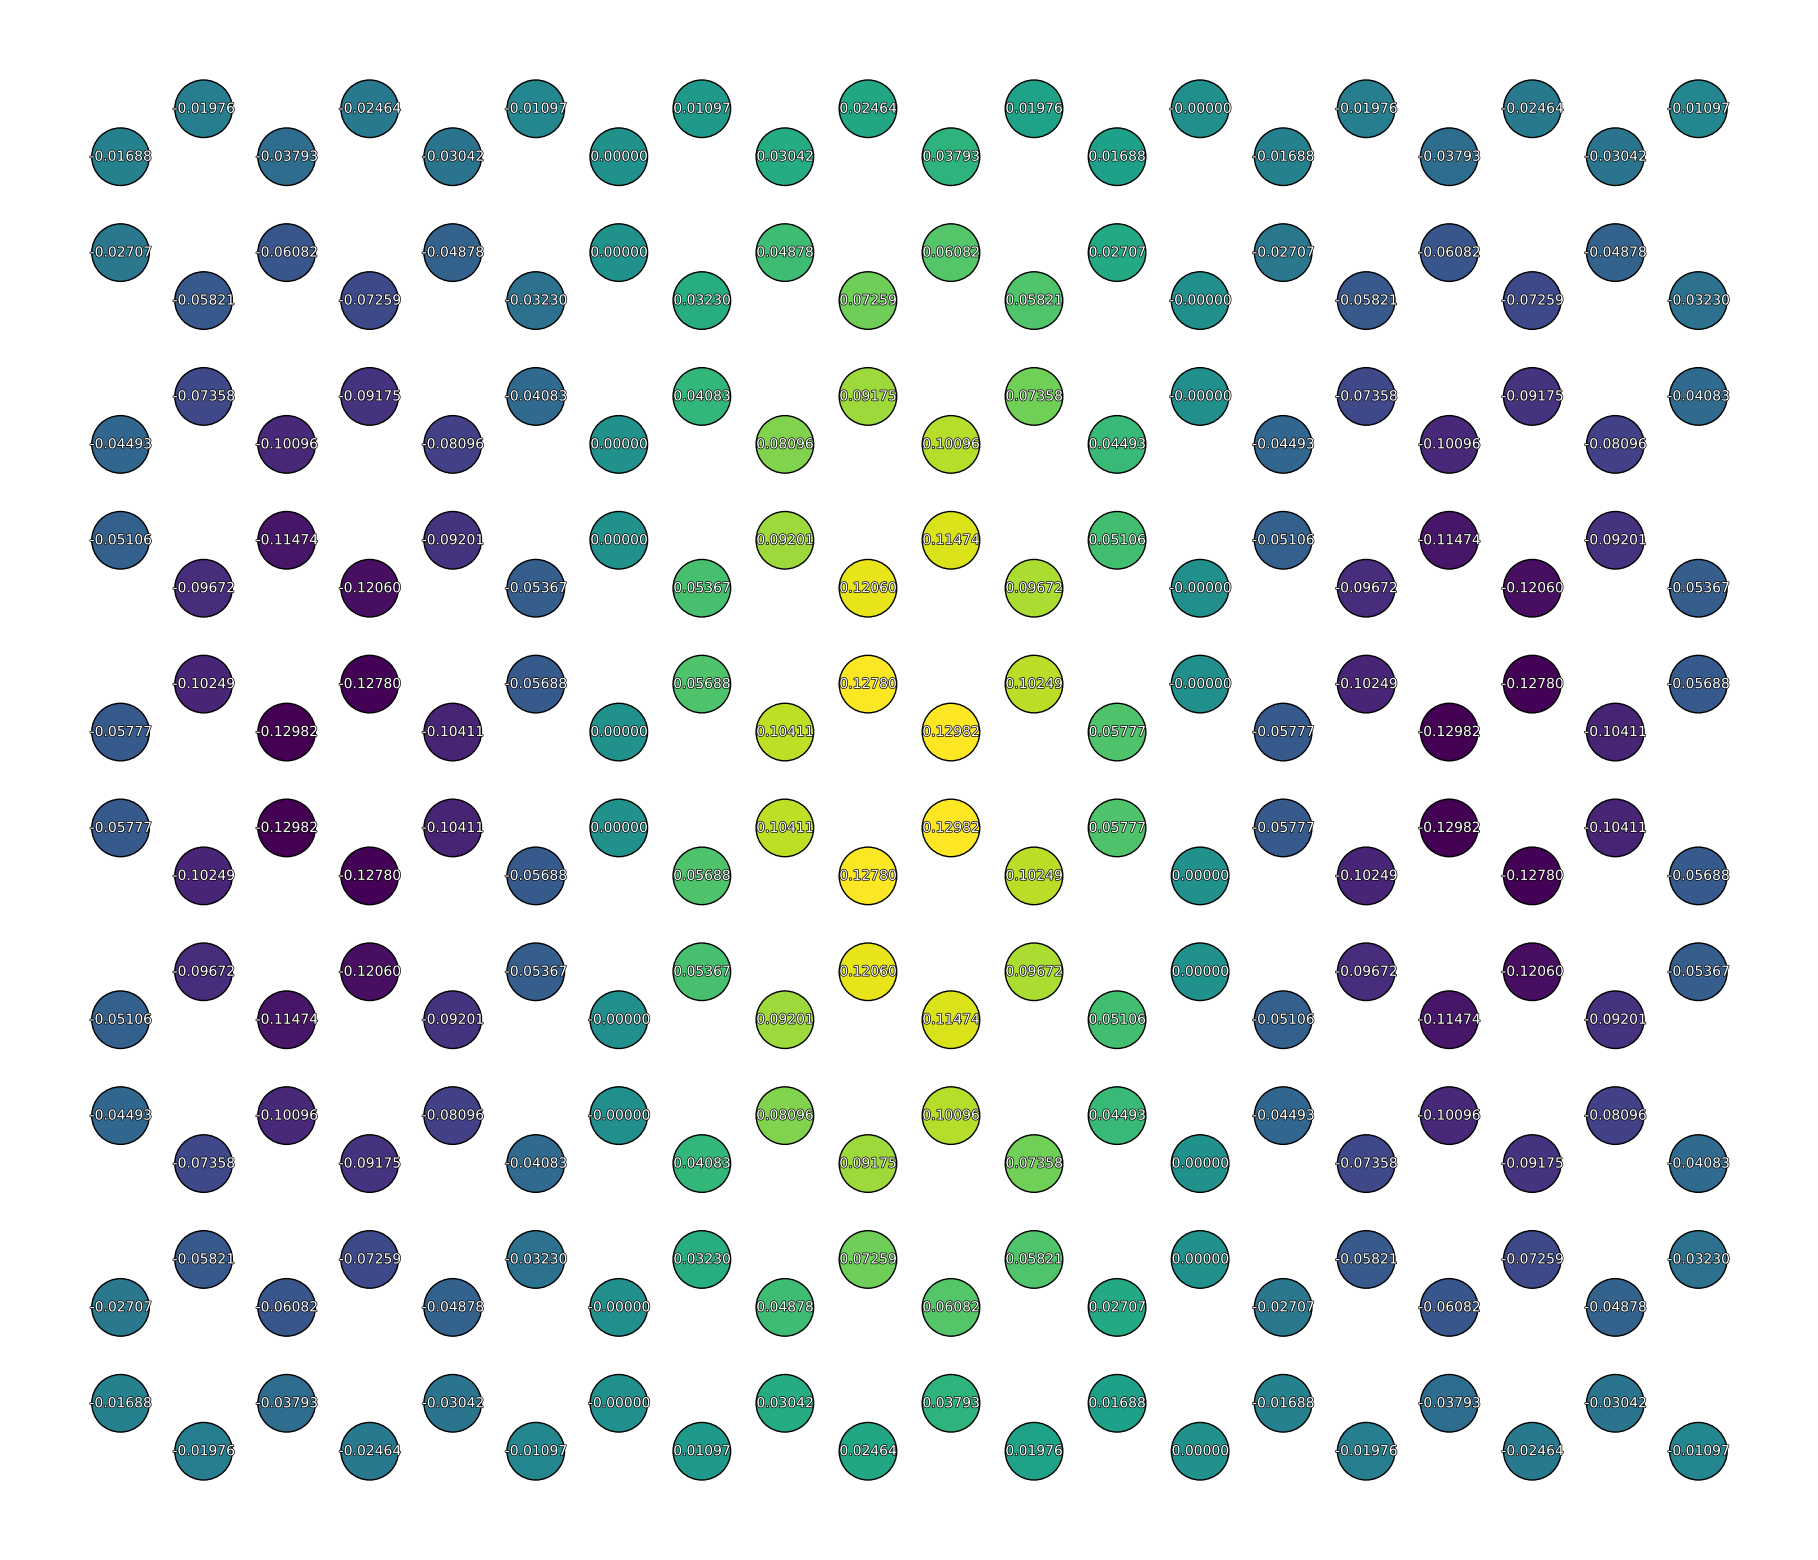

<Axes: >

In [250]:
l = Lattice2D(HexagonalLatticeGeometry((20, 10)), params)
plot_site_grid(l.energy_states[:, 4], l.geometry, cmap_name="viridis")

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.05.


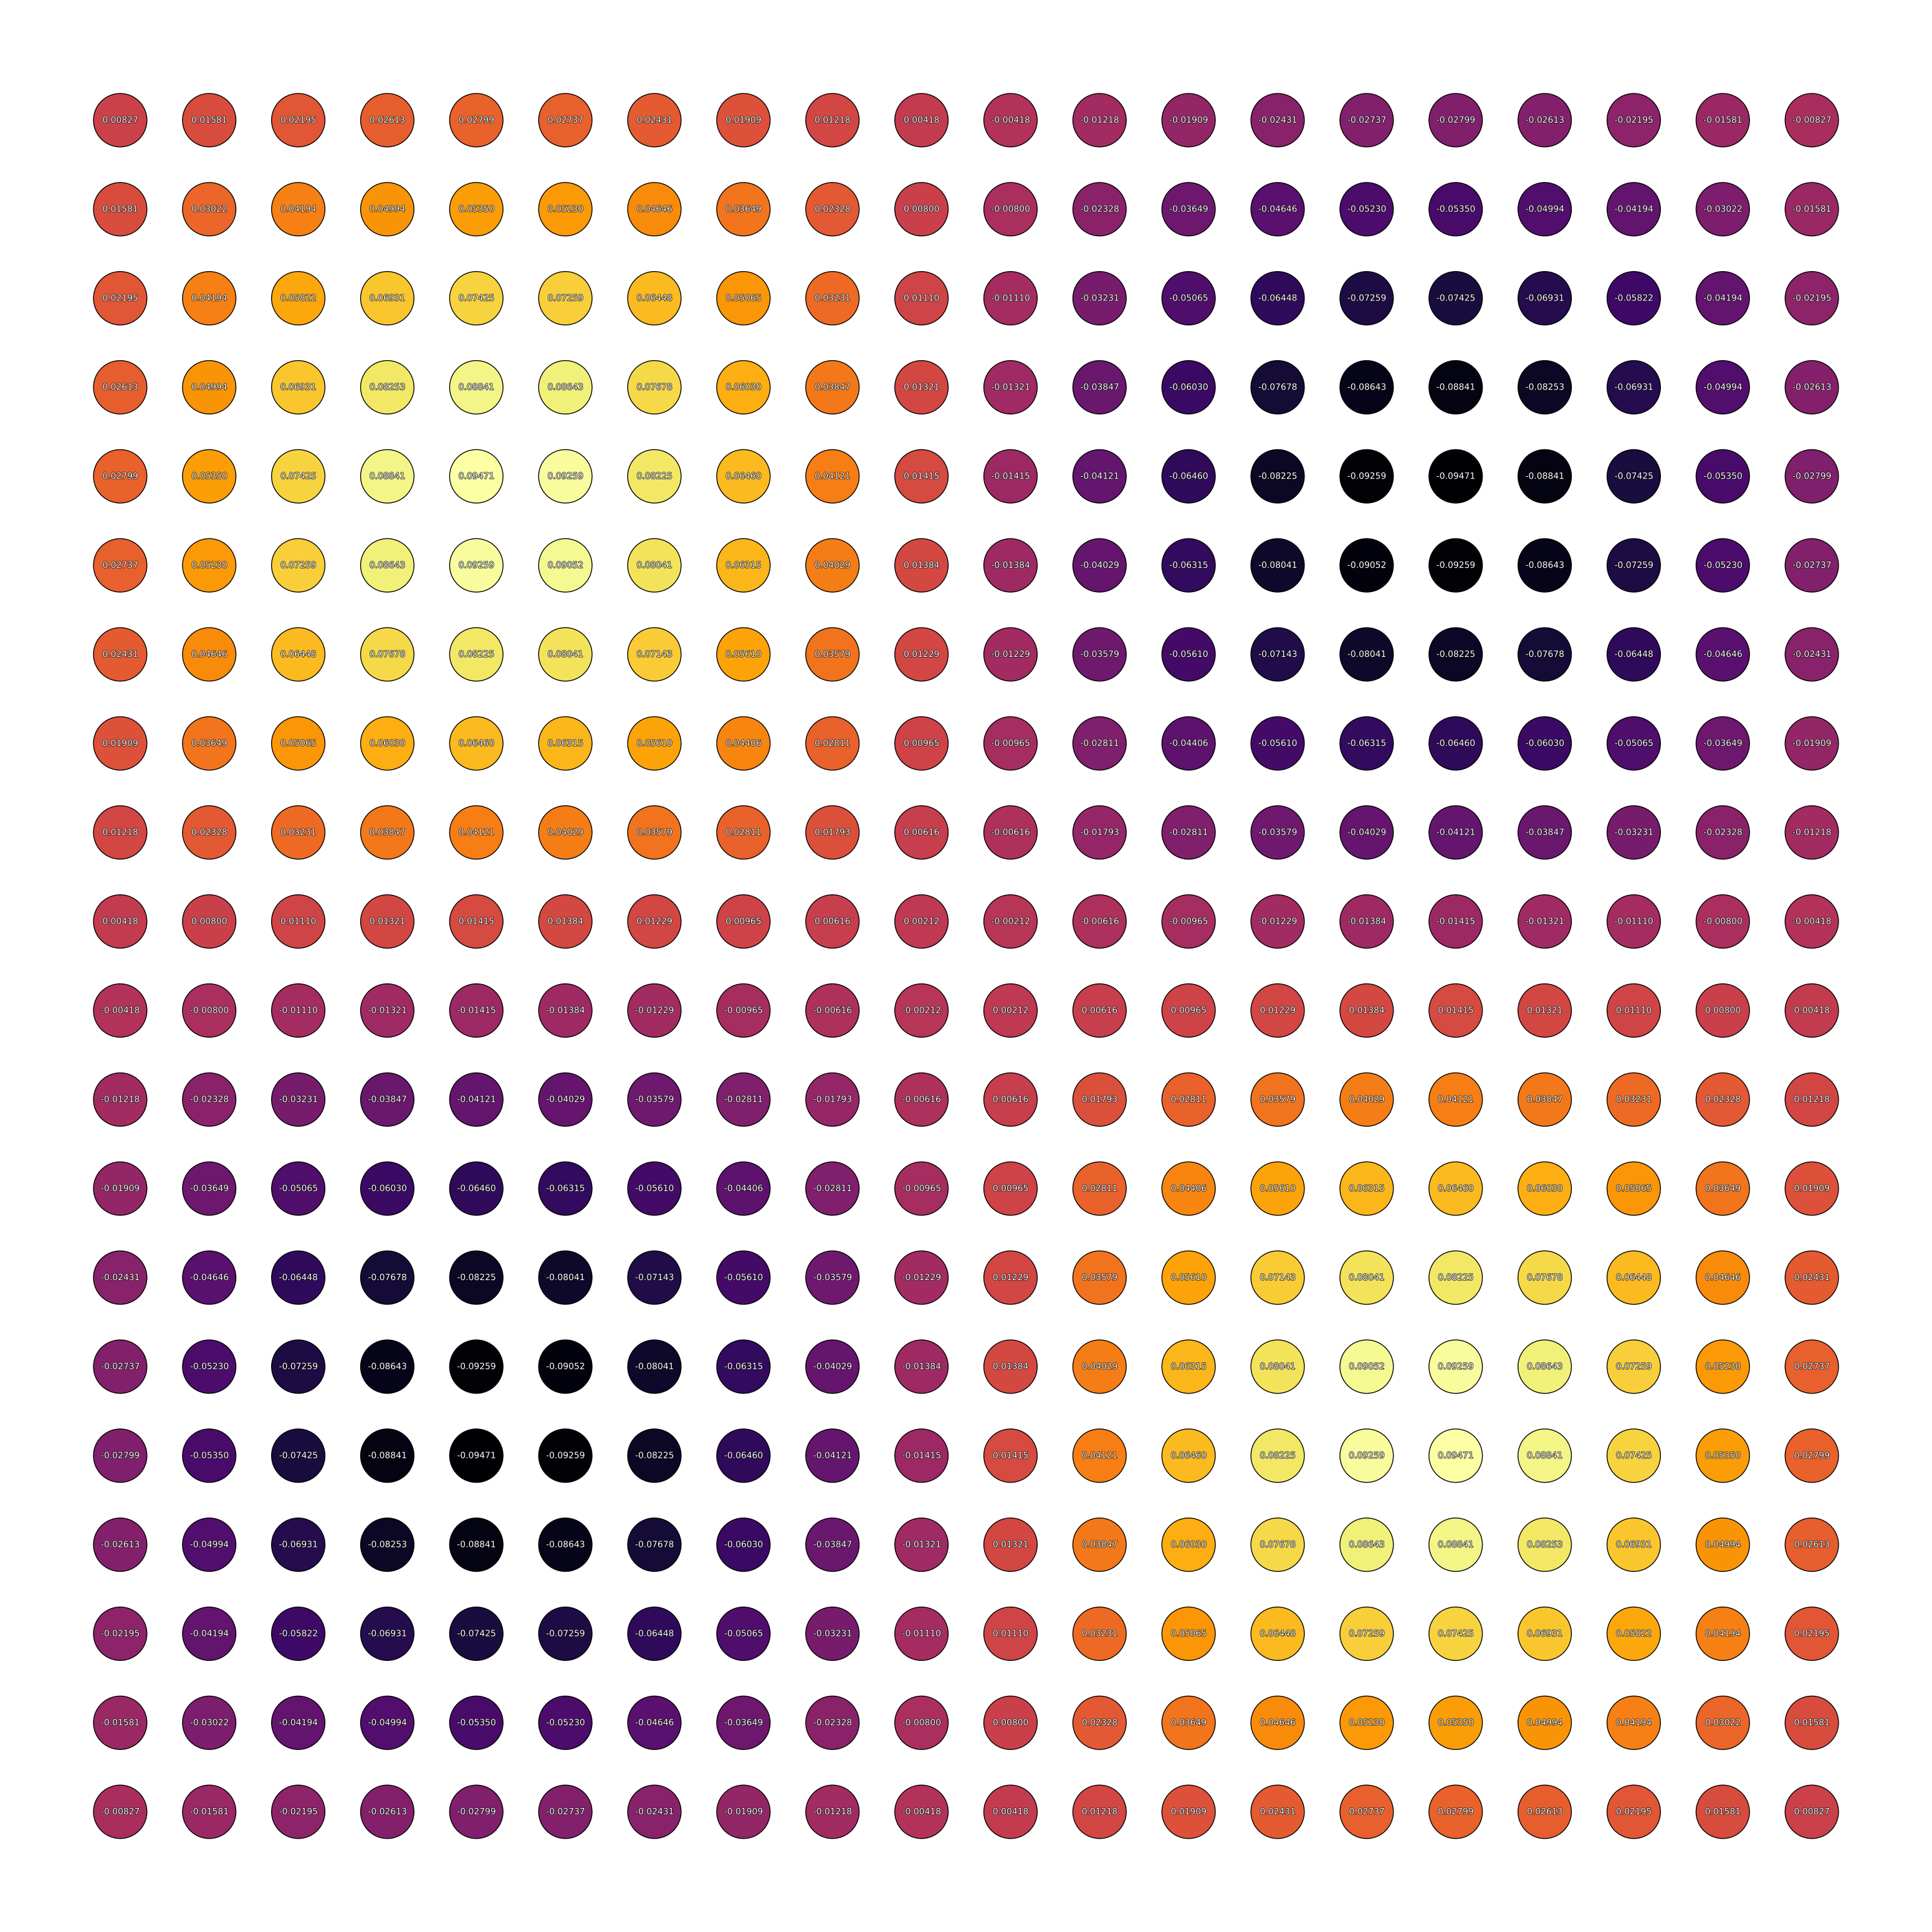

<Axes: >

In [238]:
l = Lattice2D(SquareLatticeGeometry(20), params)
plot_site_grid(l.energy_states[:, 3], l.geometry)

## Band structure

A fourier transform reveals the standing wave's frequency such that we can map the eigenenergies to wavevectors. Sign of wavevector components is fixed/undefined (?). 

To verify the mode spacing, fft bins are too coarse, one would need to fit sin(kx) to the eigenstate. Indeed, this yields the $\pi/(L+1)$ spacing.

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.05.


/Users/leonard/dev/projects/university/orbitronics_research_project/lattice/lattice.py:68: UserWarning: Site number should be even--then integer # of states can be set with half occupation.
  warnings.warn(


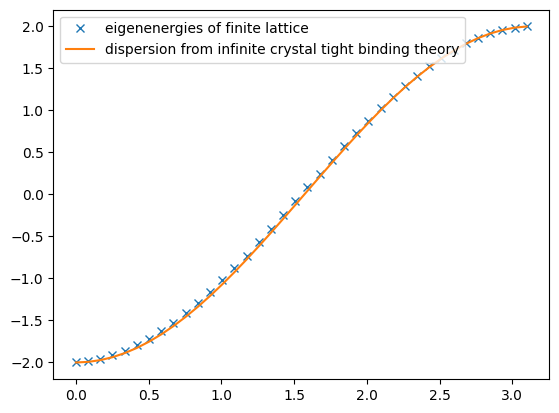

In [270]:
from lattice import plot_site_grid
from scipy.optimize import curve_fit

L = 75
l = Lattice2D(RectangularLatticeGeometry((L, 1)), params)

E_k = dict()

for i in range(L):
    state = l.energy_states[:,i]
    freqs = np.fft.fftfreq(len(state))
    fft = np.fft.fft(state)

    # Find index of maximum amplitude in FFT
    max_idx = np.argmax(np.abs(fft))
    
    # Below would work well for small N and 1D: Calculate frequency by fitting sin(k*x) to the state
    # -----------------------------------------------------------------------------------------
    # Define sine function to fit
    #def sine_func(x, k, A):
    #    return np.max(np.abs(state)) * A * np.sin(k * x)
    # x_values = np.arange(1, len(state)+1)
    # Initial guess for parameters
    # p0 = [2*np.pi*freqs[max_idx], np.max(np.abs(state))]
    # p0 = [(i+1)*np.pi / (L+1) , -1]
    # try:
    #     popt, pcov = curve_fit(sine_func, x_values, state.real, p0=p0, bounds=([-np.pi, -1], [np.pi, 1]))
    #     max_freq2 = abs(popt[0])/(2*np.pi)  # Convert angular frequency to frequency
    #     #print(f"FFT freq: {freqs[max_idx]}, Fitted freq: {max_freq2}, Fitted A: {popt[1]}")
    # except:
    #     max_freq2 = freqs[max_idx]

    max_freq = abs(freqs[max_idx])

    # print(max_freq, max_freq2, l.eigen_energies[i])
    E_k[max_freq] = l.eigen_energies[i]

x = 2*np.pi*np.array(list(E_k.keys()))

plt.plot(x, list(E_k.values()), 'x', label="eigenenergies of finite lattice")
y = -2 * np.cos(x)
plt.plot(x, y, '-', label="dispersion from infinite crystal tight binding theory")
plt.legend()
plt.show()

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


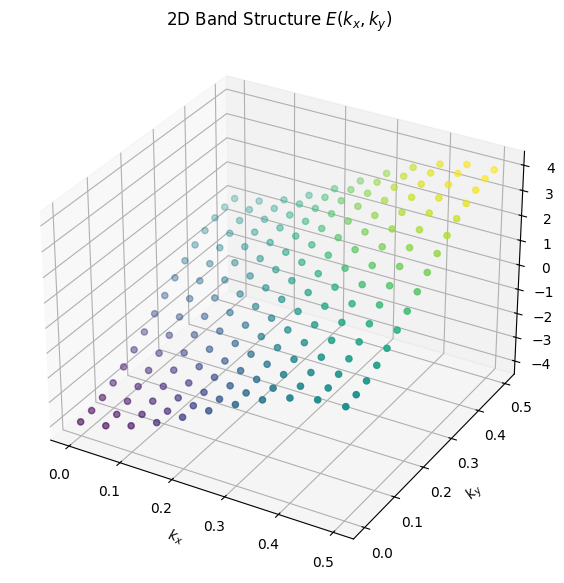

In [252]:
from lattice import plot_site_grid
import numpy as np
import matplotlib.pyplot as plt

# Define 2D lattice dimensions
Lx, Ly = 20, 30  # 2D lattice size

# Create 2D lattice
l = Lattice2D(
    RectangularLatticeGeometry((Lx, Ly)), 
    SimulationParameters(t_hop=-1, E_amplitude=1, E_direction=np.array([0, -1]), h=1, T=1, substeps=1)
)

# Dictionary to store E(kx, ky)
E_k = {}

# Loop over all eigenstates
for i in range(Lx * Ly):
    state = l.energy_states[:, i].reshape(Ly, Lx)  # Reshape to 2D grid
    fft2 = np.fft.fft2(state)
    freqs_y = np.fft.fftfreq(Ly)
    freqs_x = np.fft.fftfreq(Lx)

    # Find index of maximum amplitude in FFT (dominant wavevector)
    max_idx = np.unravel_index(np.argmax(np.abs(fft2)), fft2.shape)
    ky, kx = abs(freqs_y[max_idx[0]]), abs(freqs_x[max_idx[1]])

    # Store energy
    E_k[(kx, ky)] = l.eigen_energies[i]

# Convert to arrays for plotting
kx_vals, ky_vals, E_vals = zip(*[(kx, ky, E) for (kx, ky), E in E_k.items()])

# Plot band structure E(kx, ky) in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kx_vals, ky_vals, E_vals, c=E_vals, cmap='viridis', marker='o')

ax.set_xlabel("$k_x$")
ax.set_ylabel("$k_y$")
ax.set_title("2D Band Structure $E(k_x, k_y)$")

plt.show()


# Discrete Momenta

## Visualize time evolution of excited momenta of rect lattice under pulse

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.10.


100%|██████████| 5000/5000 [00:01<00:00, 3997.57it/s]


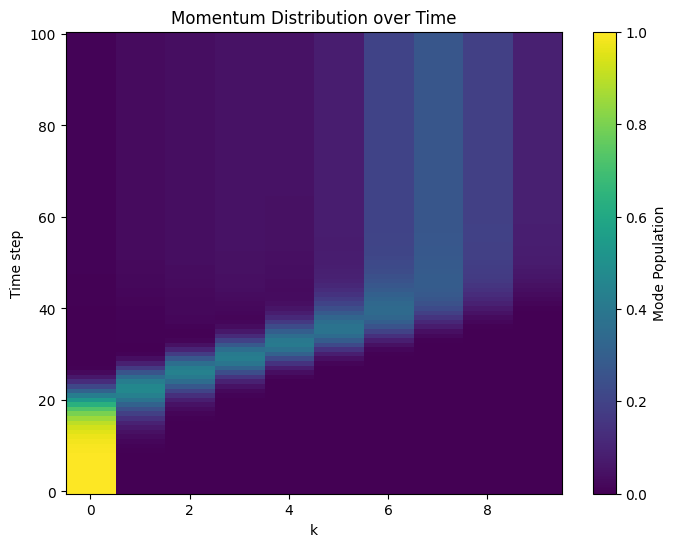

In [ ]:
N = 10


def E_pulse(t, t0, sigma, A):
    return A * np.exp(-((t - t0) ** 2) / (2 * sigma**2))


def get_1D_momentum_distributions(T=10, h=0.1, substeps=50, **pulse_kwargs):
    l = Lattice2D(
        RectangularLatticeGeometry((N, 1)),
        SimulationParameters(
            t_hop=-1,
            E_amplitude=lambda t: E_pulse(t, **pulse_kwargs),
            E_direction=np.array([1, 0]),
            h=h,
            T=T,
            substeps=substeps,
            initial_occupation=1 / (N),
        ),
    )

    l.evolve(solver="rk4")

    x = np.arange(1, N + 1)

    # Allowed discrete momenta for a 1D lattice with open boundaries:
    # k_n = n*pi/(N+1), with n=1,...,N.
    k_list = np.array([np.pi * n / (N + 1) for n in range(1, N + 1)])

    momentum_distributions = []

    for state in l.states:
        rho_t = state.density
        P_k = np.zeros(N)
        for idx, k in enumerate(k_list):
            # Construct the 1D sine basis function for momentum k:
            phi_k = np.sqrt(2 / (N + 1)) * np.sin(k * x)
            # Projection: <phi_k|rho|phi_k>
            P_k[idx] = np.real(np.dot(phi_k.conj(), rho_t @ phi_k))
        momentum_distributions.append(P_k)

    return np.array(momentum_distributions)


momentum_distributions = get_1D_momentum_distributions(t0=3, sigma=1, A=1)

plt.figure(figsize=(8, 6))
plt.imshow(momentum_distributions, aspect="auto", origin="lower")
plt.xlabel("k")
plt.ylabel("Time step")
plt.title("Momentum Distribution over Time")
plt.colorbar(label="Mode Population")
plt.show()

### Exciting with higher energy leads to (Bloch?) oscillations.

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.10.


100%|██████████| 40000/40000 [00:10<00:00, 3958.02it/s]


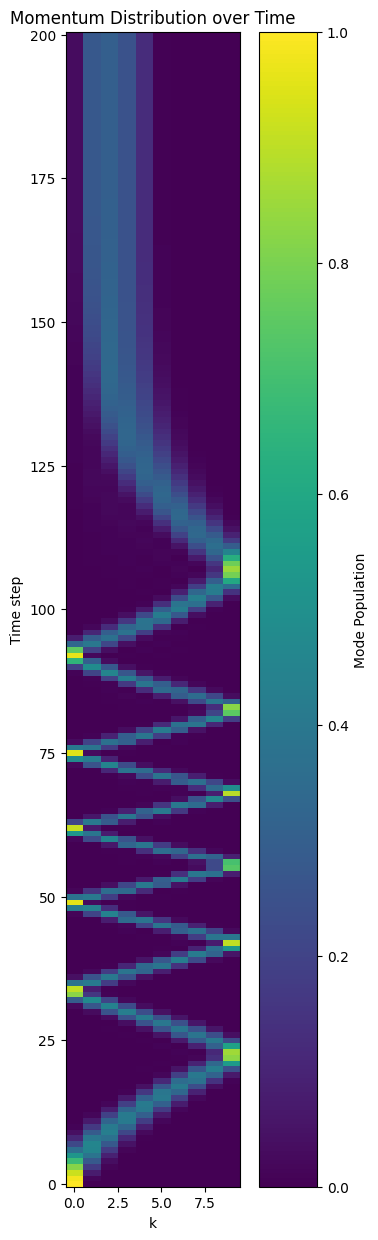

In [245]:
momentum_distributions = get_1D_momentum_distributions(T=10, h=0.05, substeps=200, t0 = 3, sigma=1.5, A=10)

plt.figure(figsize=(5, 15))
plt.imshow(momentum_distributions, aspect=0.33, origin='lower', interpolation='none')
plt.xlabel("k")
plt.ylabel("Time step")
plt.title("Momentum Distribution over Time")
plt.colorbar(label="Mode Population")
plt.show()

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.01.


100%|██████████| 1000/1000 [00:00<00:00, 1334.15it/s]


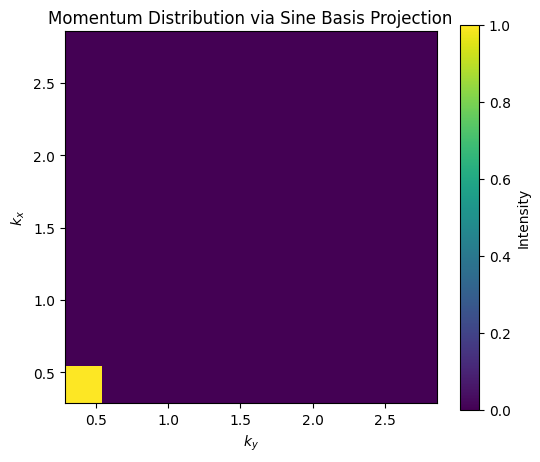

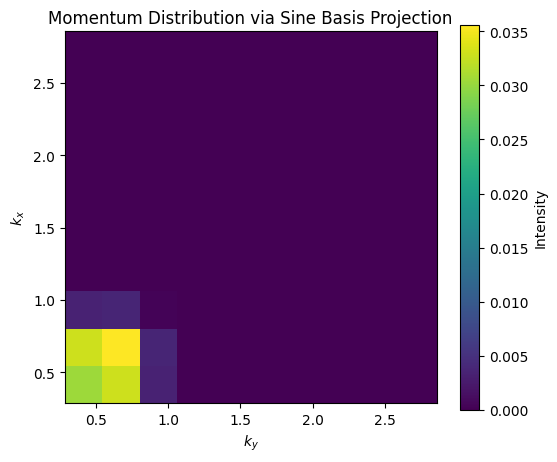

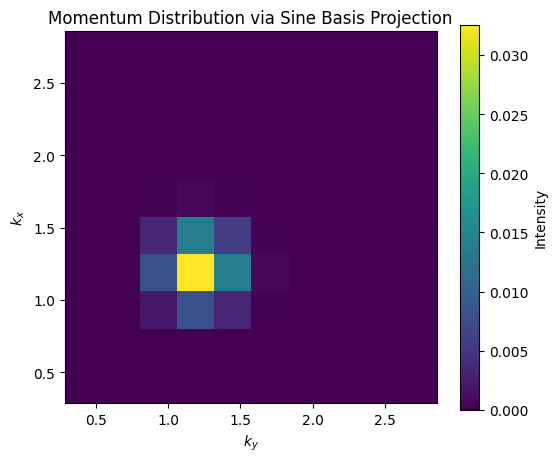

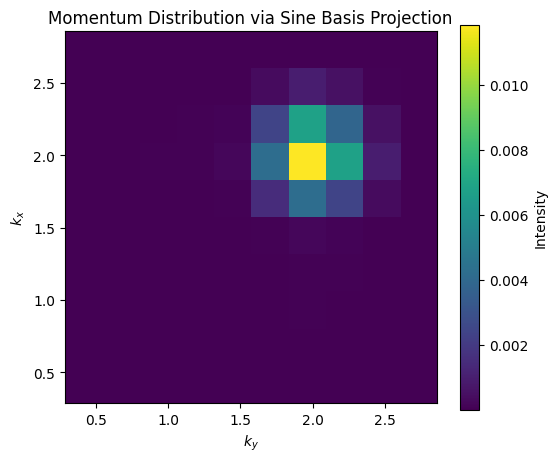

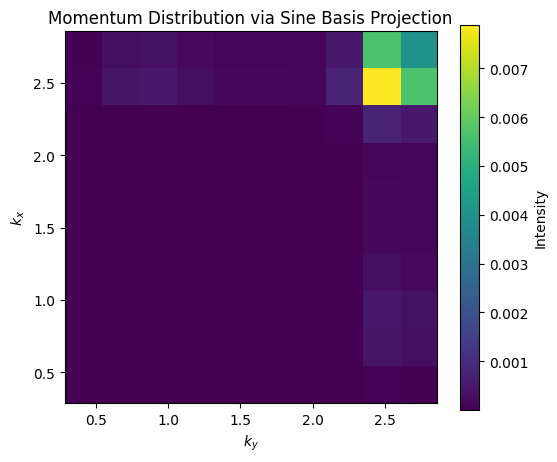

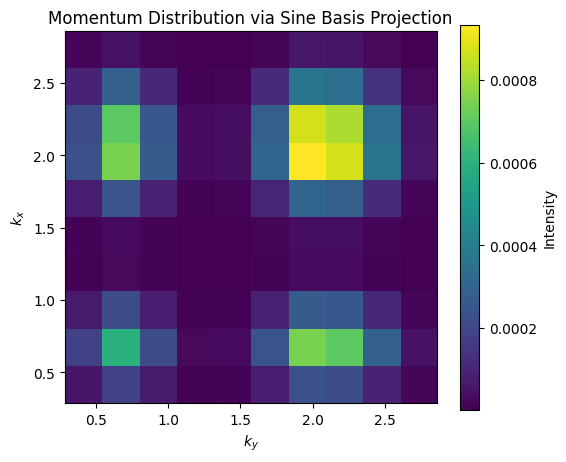

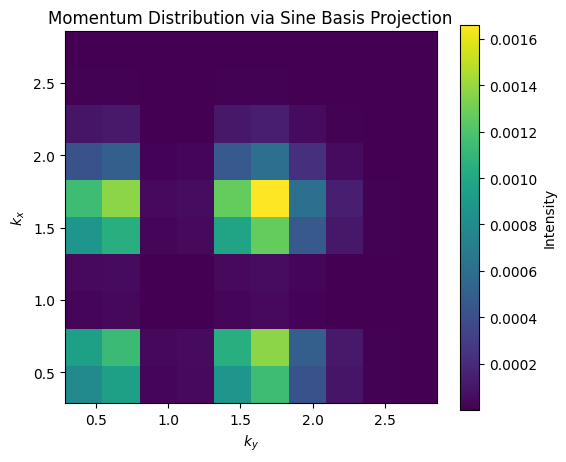

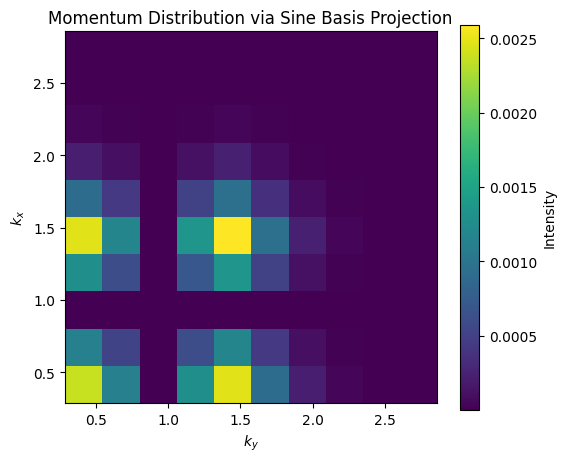

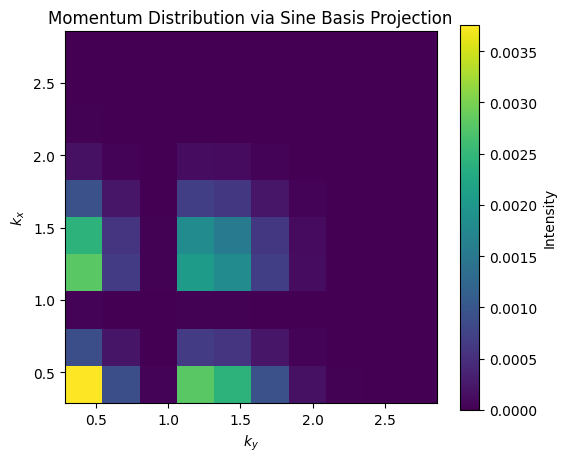

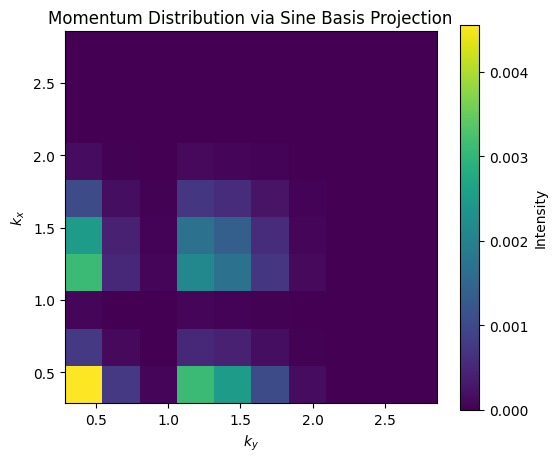

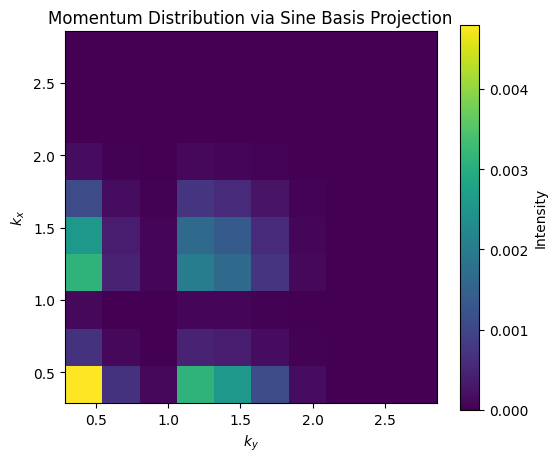

In [24]:
Nx, Ny = 10, 10
l = Lattice2D(
    RectangularLatticeGeometry((Nx, Ny)),
    SimulationParameters(
        t_hop=-1,
        E_amplitude=lambda t: E_pulse(t, 3, 2, 1),
        E_direction=np.array([1, -1]),
        h=1, T=10, substeps=100,
        initial_occupation=1/(Nx*Ny)
    )
)

l.evolve(solver="rk4")

for state in l.states:
    rho_t = state.density  # shape (N_sites, N_sites)
    N_sites = l.N

    # Get positions of sites (assumed to be arranged on a rectangular grid)
    positions = np.array([l.geometry.site_to_position(i) for i in range(N_sites)])
    # Extract unique x and y coordinates (assumes lattice is rectangular)
    x_unique, x_inv = np.unique(positions[:,0], return_inverse=True)
    y_unique, y_inv = np.unique(positions[:,1], return_inverse=True)
    Nx_sites = len(x_unique)
    Ny_sites = len(y_unique)

    # Build the sine basis projection for open boundaries.
    # For x-direction: allowed momenta k_x = n*pi/(Nx_sites+1), n = 1,...,Nx_sites.
    # For y-direction: allowed momenta k_y = m*pi/(Ny_sites+1), m = 1,...,Ny_sites.
    P_modes = np.zeros((Nx_sites, Ny_sites), dtype=complex)

    # Loop over the allowed mode indices:
    for n in range(1, Nx_sites+1):
        for m in range(1, Ny_sites+1):
            # Build the product sine basis function.
            # Note: x_inv and y_inv give indices from 0 to (Nx_sites-1) and (Ny_sites-1),
            # so add 1 to get indices 1...Nx_sites, 1...Ny_sites.
            phi_x = np.sqrt(2/(Nx_sites+1)) * np.sin(np.pi * n * (x_inv + 1) / (Nx_sites+1))
            phi_y = np.sqrt(2/(Ny_sites+1)) * np.sin(np.pi * m * (y_inv + 1) / (Ny_sites+1))
            phi_nm = phi_x * phi_y  # shape (N_sites,)
            
            # Project the density matrix onto the (n,m) mode:
            P_modes[n-1, m-1] = np.dot(phi_nm.conjugate(), np.dot(rho_t, phi_nm))

    # Define the allowed momentum values:
    kx_modes = np.array([np.pi * n / (Nx_sites+1) for n in range(1, Nx_sites+1)])
    ky_modes = np.array([np.pi * m / (Ny_sites+1) for m in range(1, Ny_sites+1)])

    # Plot the mode intensity |P_modes|^2 as a function of (k_x, k_y)
    plt.figure(figsize=(6,5))
    plt.imshow(np.abs(P_modes)**2, origin='lower', aspect=Nx/Ny,
            extent=[ky_modes[0], ky_modes[-1], kx_modes[0], kx_modes[-1]])
    plt.xlabel('$k_y$')
    plt.ylabel('$k_x$')
    plt.colorbar(label='Intensity')
    plt.title('Momentum Distribution via Sine Basis Projection')
    plt.show()


### Momentum response to oscillating field

In [294]:
np.diff(l.eigen_energies).min()

np.float64(0.2364788815666321)

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.10.


100%|██████████| 8000/8000 [00:01<00:00, 4188.83it/s]


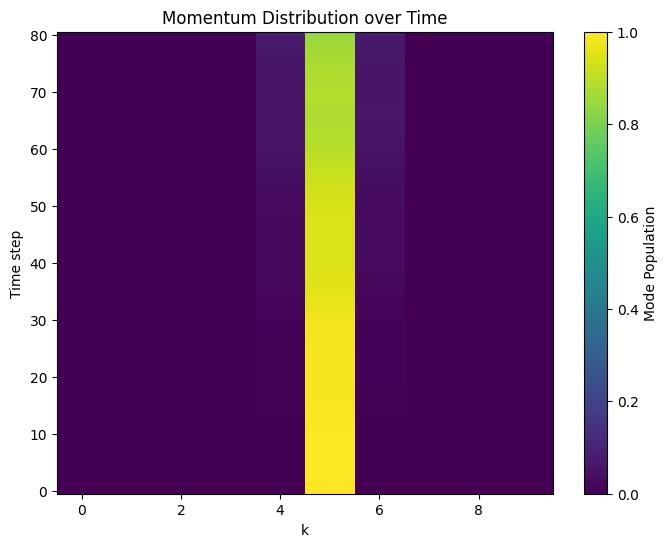

In [294]:
N = 10


def E_osc(t, w, A):
    return A * np.sin(w * t)


def get_1D_momentum_distributions_osc(T=10, h=0.1, substeps=50, **pulse_kwargs):
    l = Lattice2D(
        RectangularLatticeGeometry((N, 1)),
        SimulationParameters(
            t_hop=-1,
            E_amplitude=lambda t: E_osc(t, **pulse_kwargs),
            E_direction=np.array([1, 0]),
            h=h,
            T=T,
            substeps=substeps,
            initial_occupation=1 / (N),
        ),
    )

    rho_energy_basis = np.diag(np.zeros(N))
    rho_energy_basis[N//2, N//2] = 1
    l.density_matrix = l.energy_states @ rho_energy_basis @ l.energy_states.T.conj()

    l.evolve(solver="rk4")

    x = np.arange(1, N + 1)

    # Allowed discrete momenta for a 1D lattice with open boundaries:
    # k_n = n*pi/(N+1), with n=1,...,N.
    k_list = np.array([np.pi * n / (N + 1) for n in range(1, N + 1)])

    momentum_distributions = []

    for state in l.states:
        rho_t = state.density
        P_k = np.zeros(N)
        for idx, k in enumerate(k_list):
            # Construct the 1D sine basis function for momentum k:
            phi_k = np.sqrt(2 / (N + 1)) * np.sin(k * x)
            # Projection: <phi_k|rho|phi_k>
            P_k[idx] = np.real(np.dot(phi_k.conj(), rho_t @ phi_k))
        momentum_distributions.append(P_k)

    return np.array(momentum_distributions)


momentum_distributions = get_1D_momentum_distributions_osc(T=40, h=0.5, substeps=100, w=0.02, A=0.1)

plt.figure(figsize=(8, 6))
plt.imshow(momentum_distributions, aspect="auto", origin="lower", interpolation='none')
plt.xlabel("k")
plt.ylabel("Time step")
plt.title("Momentum Distribution over Time")
plt.colorbar(label="Mode Population")
plt.show()

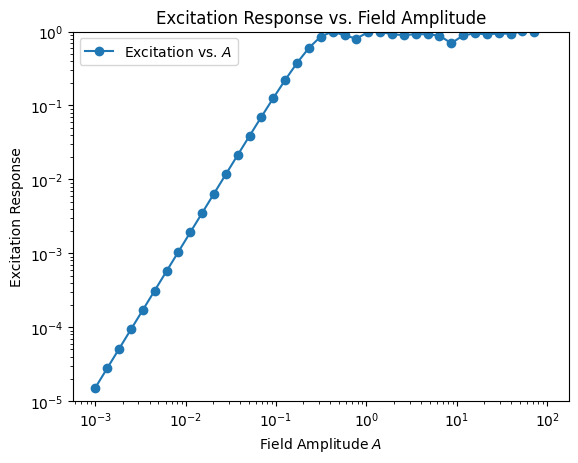

In [ ]:
A_values = np.logspace(-3, 10, 100)  # Test A from 0.01 to 10

# uncomment below to re-run simulations
# responses = []

# for A in A_values:
#     momentum_distributions = get_1D_momentum_distributions_osc(T=40, h=0.5, substeps=100, w=0.02, A=A)
    
#     # Measure total spread in momentum states (e.g., std of momentum population)
#     total_excitation = 1-momentum_distributions[-5:, 5].mean()
#     responses.append(total_excitation)

plt.loglog(A_values, responses, "o-", label=r"Excitation vs. $A$")
plt.xlabel(r"Field Amplitude $A$")
plt.ylabel("Excitation Response")
plt.title("Excitation Response vs. Field Amplitude")
plt.ylim(1e-5, 1)
plt.legend()
plt.show()


In [297]:
mask = slice(0, 15)
x = np.log(A_values[mask])
y = np.log(responses[mask])

slope, intercept = np.polyfit(x, y, 1)
print("Power law exponent:", slope)

Power law exponent: 1.9959645891504338


Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


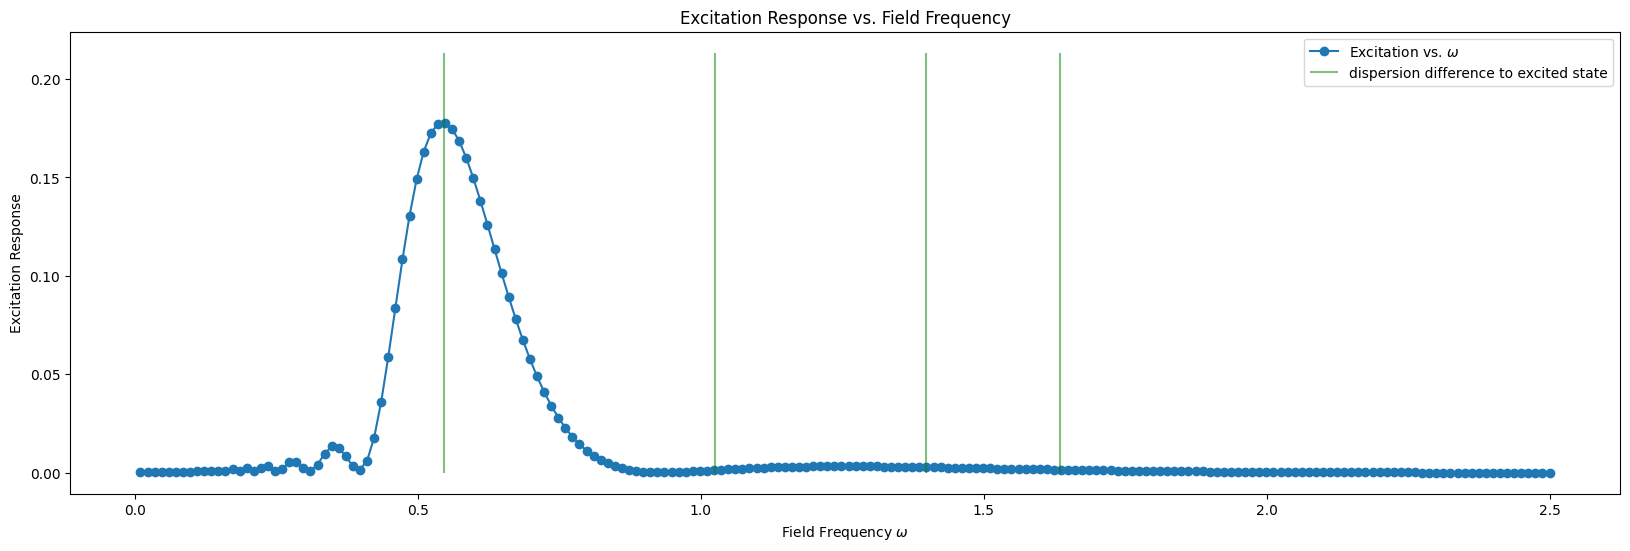

In [335]:
import pickle

# simulation was run multiprocessed
with open("excitation_responses.pkl", "rb") as f:
    omega_values, responses = pickle.load(f)

# omega_values = np.logspace(-3, 0, 100)  # Sweep from low to high frequencies
# responses = []

# for w in omega_values:
#     T = 5*np.pi/w
#     momentum_distributions = get_1D_momentum_distributions_osc(T=T, h=T/100, substeps=200, w=w, A=0.01)

#     # Measure total excitation
#     total_excitation = 1-momentum_distributions[-5:, 5].mean()
#     responses.append(total_excitation)


plt.figure(figsize=(20, 6))
plt.plot(omega_values, responses, "o-", label=r"Excitation vs. $\omega$")

energies = Lattice2D(RectangularLatticeGeometry((N, 1)), SimulationParameters.default()).eigen_energies

diffs = energies-energies[5]
diffs = diffs[diffs > 0]

plt.vlines(diffs, 0, 1.2 * np.nanmax(responses), color="green", label="dispersion difference to excited state", alpha=0.5)

plt.xlabel(r"Field Frequency $\omega$")
plt.ylabel("Excitation Response")
plt.title("Excitation Response vs. Field Frequency")
plt.legend(loc="upper right")
plt.show()